In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

# Import the dataset
df = pd.read_csv("C:\\Users\\Nishtha Sethi\\Downloads\\Austin_Animal_Center_Outcomes.csv")

# Getting file information
print("First few rows of the dataset:")
print(df.head())
print("\nDataset Info:")
print(df.info())

# Cleaning up the data
df.replace('', pd.NA, inplace=True)
df['Outcome Type'] = df['Outcome Type'].replace('Unknown', 'Other')
df['Sex upon Outcome'] = df['Sex upon Outcome'].replace('Unknown', 'Intact')
df['Animal Type'] = df['Animal Type'].replace('Unknown', 'Other')
df['Breed'] = df['Breed'].replace('Unknown', 'Mixed')
df['Color'] = df['Color'].replace('Unknown', 'Brown/Black')
df['Name'] = df['Name'].replace(np.nan, 'No Name')

for col in ['Outcome Type', 'Sex upon Outcome', 'Animal Type', 'Breed', 'Color', 'Age upon Outcome']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])
df.drop_duplicates(inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')
df = df.dropna(subset=['DateTime'])
df.dropna(inplace=True)
print("\nMissing values after final cleaning:")
print(df.isnull().sum())


First few rows of the dataset:
  Animal ID       Name                DateTime MonthYear Date of Birth  \
0   A882831  *Hamilton  07/01/2023 06:12:00 PM  Jul 2023    03/25/2023   
1   A794011      Chunk  05/08/2019 06:20:00 PM  May 2019    05/02/2017   
2   A776359      Gizmo  07/18/2018 04:02:00 PM  Jul 2018    07/12/2017   
3   A821648        NaN  08/16/2020 11:38:00 AM  Aug 2020    08/16/2019   
4   A720371      Moose  02/13/2016 05:59:00 PM  Feb 2016    10/08/2015   

  Outcome Type Outcome Subtype Animal Type Sex upon Outcome Age upon Outcome  \
0     Adoption             NaN         Cat    Neutered Male         3 months   
1    Rto-Adopt             NaN         Cat    Neutered Male          2 years   
2     Adoption             NaN         Dog    Neutered Male           1 year   
3   Euthanasia             NaN       Other          Unknown           1 year   
4     Adoption             NaN         Dog    Neutered Male         4 months   

                                Breed      


Live Outcome Rate: 84.70%
Non-Live Outcome Rate: 15.30%


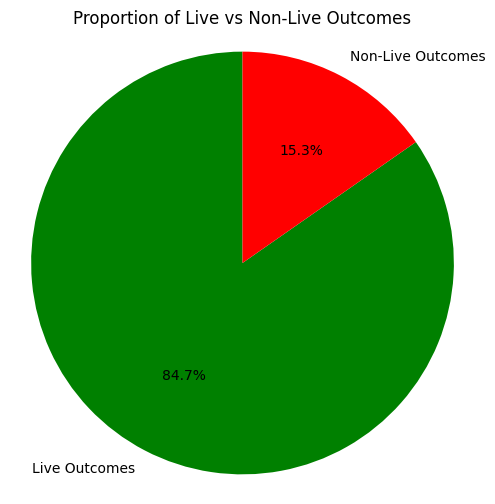

In [2]:
# ========== Objective 1: Quantify "No-Kill" policy ==========
live_outcomes = ['Adoption', 'Transfer', 'Return to Owner']
df['Is_Live'] = df['Outcome Type'].isin(live_outcomes)
live_rate = df['Is_Live'].mean() * 100
non_live_rate = 100 - live_rate
print(f"\nLive Outcome Rate: {live_rate:.2f}%")
print(f"Non-Live Outcome Rate: {non_live_rate:.2f}%")
outcome_counts = df['Is_Live'].value_counts()
labels = ['Live Outcomes', 'Non-Live Outcomes']
colors = ['green', 'red']
plt.figure(figsize=(6, 6))
plt.pie(outcome_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Live vs Non-Live Outcomes')
plt.axis('equal')
plt.show()

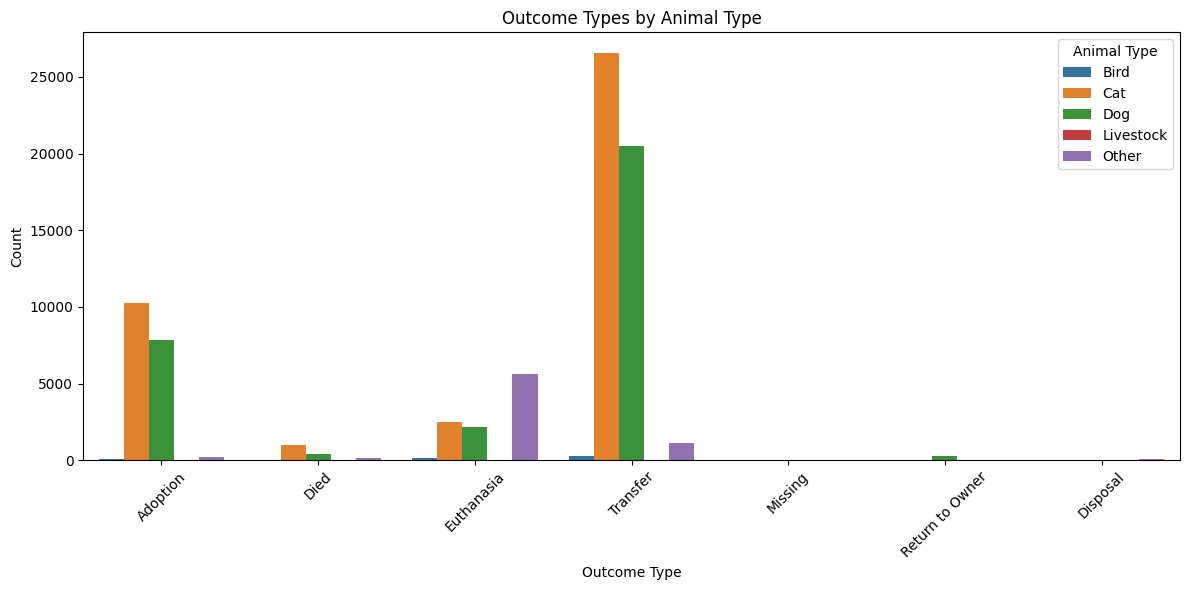

In [3]:
# ========== Objective 2: Analyze outcome types across animal types ==========
grouped = df.groupby(['Animal Type', 'Outcome Type']).size().reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Outcome Type', y='Count', hue='Animal Type')
plt.xticks(rotation=45)
plt.title('Outcome Types by Animal Type')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.legend(title='Animal Type')
plt.tight_layout()
plt.show()

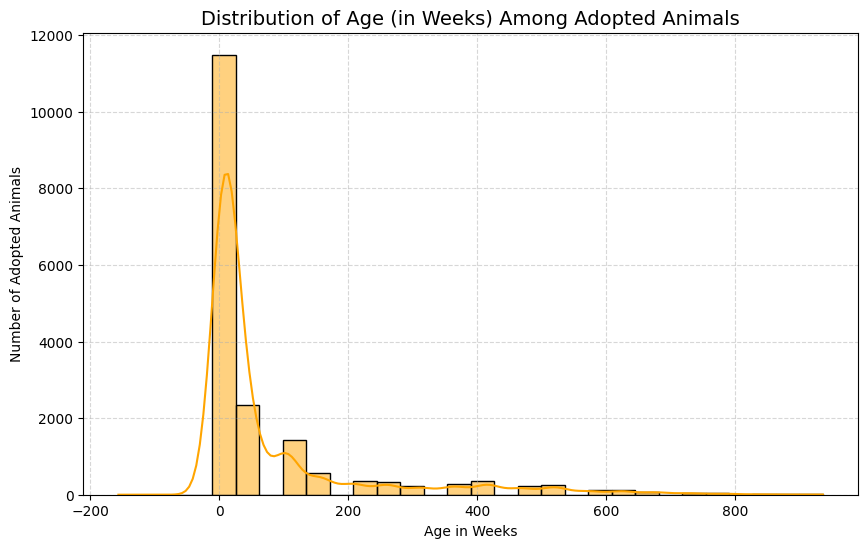

In [4]:
# ========== Objective 3: Effect of Age on Outcomes ==========
def convert_age_to_weeks(age_str):
    try:
        number, unit = age_str.split()[:2]
        number = int(number)
        unit = unit.lower()
        if 'day' in unit:
            return number / 7
        elif 'week' in unit:
            return number
        elif 'month' in unit:
            return number * 4
        elif 'year' in unit:
            return number * 52
        else:
            return None
    except:
        return None

df['AgeWeeks'] = df['Age upon Outcome'].apply(convert_age_to_weeks)
adopted_df = df[df['Outcome Type'] == 'Adoption'].copy()
adopted_df.dropna(subset=['AgeWeeks'], inplace=True)
plt.figure(figsize=(10, 6))
sns.histplot(adopted_df['AgeWeeks'], bins=30, kde=True, color='orange')
plt.title('Distribution of Age (in Weeks) Among Adopted Animals', fontsize=14)
plt.xlabel('Age in Weeks')
plt.ylabel('Number of Adopted Animals')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



Outcome distribution by Neutering status:
Outcome Type       Adoption      Died  Disposal  Euthanasia   Missing  \
Sex upon Outcome                                                        
Intact             0.827275  2.933066  0.401103   50.438706  0.025069   
Intact Female      1.600481  2.623345  0.000000    7.749699  0.144404   
Intact Male        1.452877  3.268973  0.012745   10.093672  0.165679   
Neutered Male     47.771992  0.668676  0.005481    5.212387  0.021924   
Spayed Female     54.096104  0.670217  0.005984    3.644306  0.089761   

Outcome Type      Return to Owner   Transfer  
Sex upon Outcome                              
Intact                   0.075207  45.299574  
Intact Female            0.361011  87.521059  
Intact Male              0.484292  84.521761  
Neutered Male            0.515210  45.804330  
Spayed Female            0.275268  41.218359  

Adoption Rate (%) by Sex upon Outcome:
Sex upon Outcome
Neutered Male    47.771992
Spayed Female    54.096104
Intac

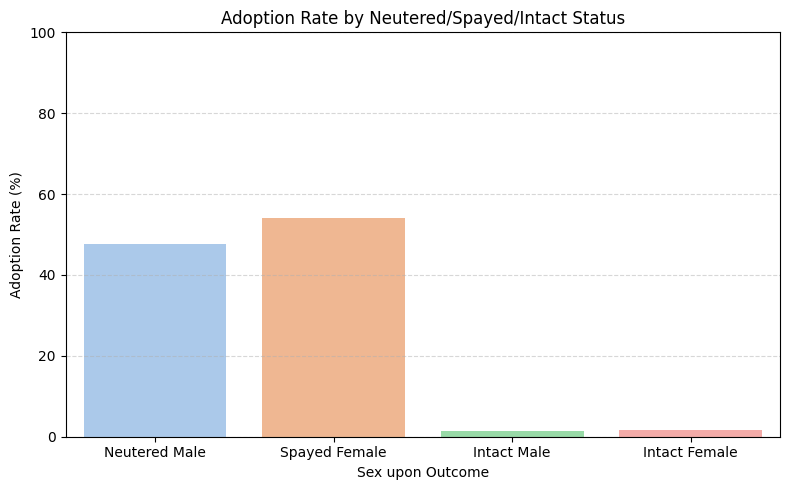

In [5]:
# ========== Objective 4: Effect of Neutered/Spayed on Outcome ==========
print("\nOutcome distribution by Neutering status:")
neuter_outcome = pd.crosstab(df['Sex upon Outcome'], df['Outcome Type'], normalize='index') * 100
print(neuter_outcome)
statuses = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female']
df_filtered = df[df['Sex upon Outcome'].isin(statuses)]
adopt_counts = df_filtered[df_filtered['Outcome Type'] == 'Adoption']['Sex upon Outcome'].value_counts()
total_counts = df_filtered['Sex upon Outcome'].value_counts()
adoption_rates = (adopt_counts / total_counts * 100).reindex(statuses).fillna(0)
print("\nAdoption Rate (%) by Sex upon Outcome:")
print(adoption_rates)
plt.figure(figsize=(8, 5))
sns.barplot(x=adoption_rates.index, y=adoption_rates.values, 
            hue=adoption_rates.index, palette='pastel', legend=False)
plt.title('Adoption Rate by Neutered/Spayed/Intact Status')
plt.ylabel('Adoption Rate (%)')
plt.xlabel('Sex upon Outcome')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

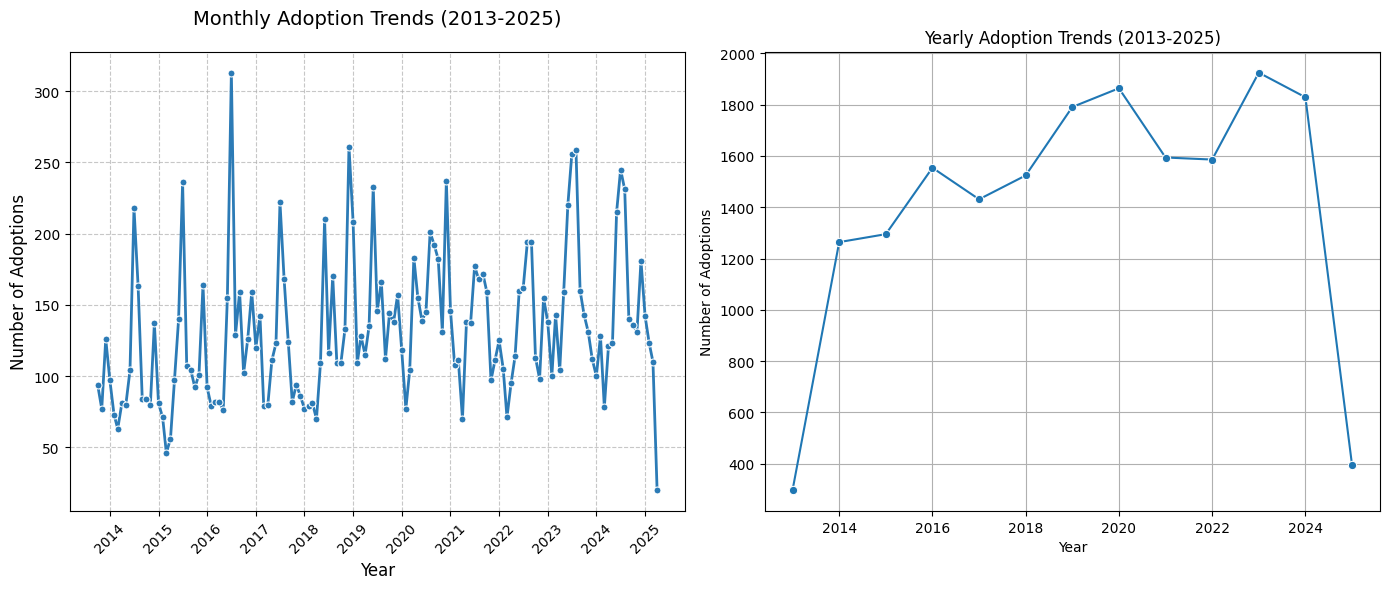

In [6]:
# ========== Objective 5: Adoption Trends Over Time ==========
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['YearMonth'] = df['DateTime'].dt.to_period('M')
adoptions = df[df['Outcome Type'] == 'Adoption']
monthly_adoptions = adoptions.groupby('YearMonth').size().reset_index(name='AdoptionCount')
monthly_adoptions['YearMonth'] = monthly_adoptions['YearMonth'].dt.to_timestamp()
yearly_adoptions = adoptions.groupby('Year').size().reset_index(name='AdoptionCount')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
ax1 = plt.gca()
sns.lineplot(data=monthly_adoptions, x='YearMonth', y='AdoptionCount', 
             color='#2c7bb6', linewidth=2, marker='o', markersize=5, ax=ax1)
plt.title('Monthly Adoption Trends (2013-2025)', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Adoptions', fontsize=12)
ax1.xaxis.set_major_locator(YearLocator())
ax1.xaxis.set_major_formatter(DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.subplot(1, 2, 2)
sns.lineplot(data=yearly_adoptions, x='Year', y='AdoptionCount', marker='o')
plt.title('Yearly Adoption Trends (2013-2025)')
plt.xlabel('Year')
plt.ylabel('Number of Adoptions')
plt.grid(True)
plt.tight_layout()
plt.show()

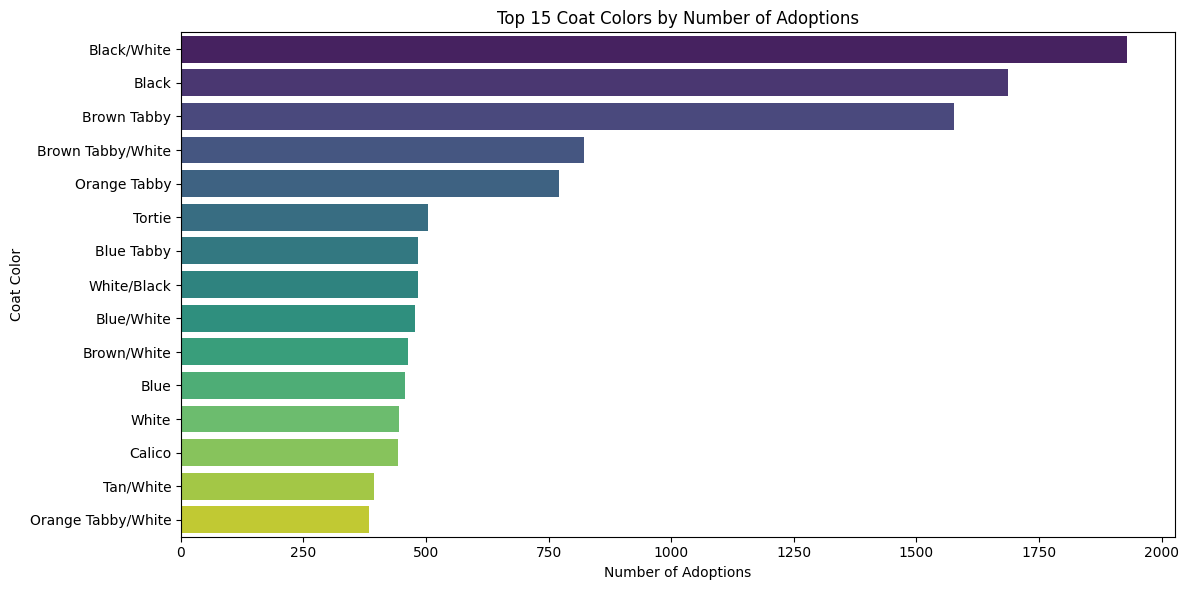

In [7]:
# ========== Objective 6: Color impact on outcomes ==========
adopted_df = df[df['Outcome Type'] == 'Adoption']
color_adoptions = adopted_df.groupby('Color').size().reset_index(name='Adoption Count')
top_colors = color_adoptions.sort_values(by='Adoption Count', ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_colors, x='Adoption Count', y='Color', hue='Color', palette='viridis', legend=False)
plt.title('Top 15 Coat Colors by Number of Adoptions')
plt.xlabel('Number of Adoptions')
plt.ylabel('Coat Color')
plt.tight_layout()
plt.show()


Chances of Specific Outcomes by Species (in %):
Outcome Type  Adoption  Died  Disposal  Euthanasia  Missing  Return to Owner  \
Animal Type                                                                    
Bird             10.79  5.70       NaN       30.35      NaN              NaN   
Cat              25.36  2.40       NaN        6.23     0.11             0.08   
Dog              25.18  1.24      0.01        7.01     0.08             0.81   
Livestock        57.69  3.85       NaN        7.69      NaN              NaN   
Other             2.59  2.09      0.67       78.61     0.03             0.01   

Outcome Type  Transfer  
Animal Type             
Bird             53.16  
Cat              65.82  
Dog              65.66  
Livestock        30.77  
Other            15.99  


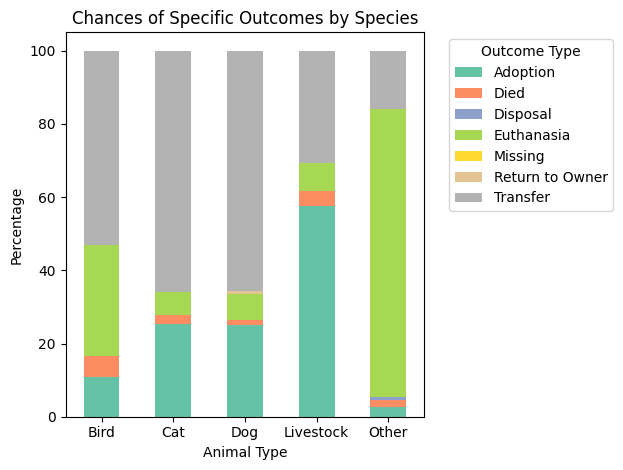

In [8]:
# ========== Objective 7: Chances of specific outcomes by species ==========
species_outcome_chances = df.groupby(['Animal Type', 'Outcome Type']).size().unstack()
species_outcome_percent = species_outcome_chances.div(species_outcome_chances.sum(axis=1), axis=0) * 100
print("\nChances of Specific Outcomes by Species (in %):")
print(species_outcome_percent.round(2))
species_outcome_percent.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Chances of Specific Outcomes by Species')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Outcome Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Chances of Specific Outcomes by Top Breeds (in %):
Outcome Type              Adoption  Died  Disposal  Euthanasia  Missing  \
Breed                                                                     
Domestic Shorthair Mix       20.59  2.10      0.00        6.50     0.11   
Domestic Shorthair           31.29  2.77      0.00        5.14     0.12   
Pit Bull Mix                 21.96  0.92      0.00       15.66     0.31   
Labrador Retriever Mix       30.76  1.08      0.03        5.45     0.10   
Chihuahua Shorthair Mix      21.20  1.73      0.00        6.71     0.04   
Bat                           0.00  1.62      1.32       97.01     0.00   
Domestic Medium Hair Mix     23.47  2.60      0.00        7.71     0.10   
Bat Mix                       0.00  1.55      0.13       98.32     0.00   
German Shepherd Mix          31.09  1.00      0.00        6.55     0.00   
Domestic Medium Hair         37.09  2.77      0.00        6.26     0.00   

Outcome Type              Return to Owner  Tran

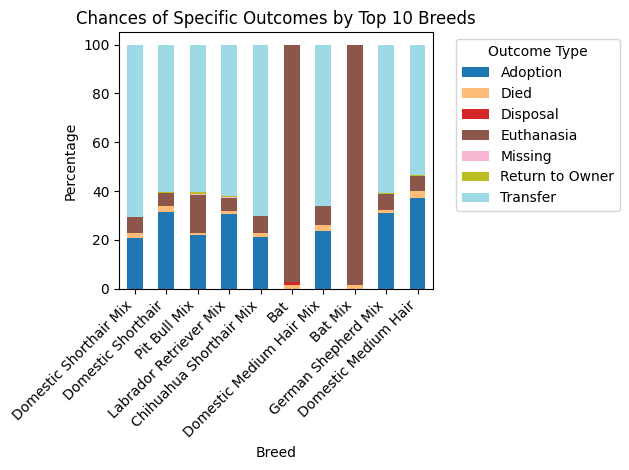

In [9]:
# ========== Objective 8: Chances of specific outcomes by breed ==========
breed_outcome_counts = df.groupby(['Breed', 'Outcome Type']).size().unstack(fill_value=0)
breed_outcome_percent = breed_outcome_counts.div(breed_outcome_counts.sum(axis=1), axis=0) * 100
top_breeds = df['Breed'].value_counts().head(10).index
top_breed_outcomes = breed_outcome_percent.loc[top_breeds]
print("\nChances of Specific Outcomes by Top Breeds (in %):")
print(top_breed_outcomes.round(2))
top_breed_outcomes.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Chances of Specific Outcomes by Top 10 Breeds')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Outcome Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

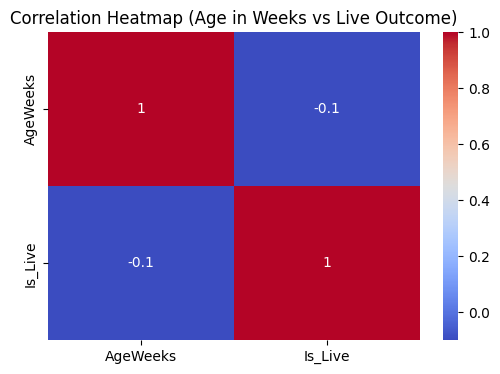

In [10]:
# ========== Correlation Heatmap using AgeWeeks ==========
plt.figure(figsize=(6, 4))
sns.heatmap(df[['AgeWeeks', 'Is_Live']].dropna().corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Age in Weeks vs Live Outcome)')
plt.show()

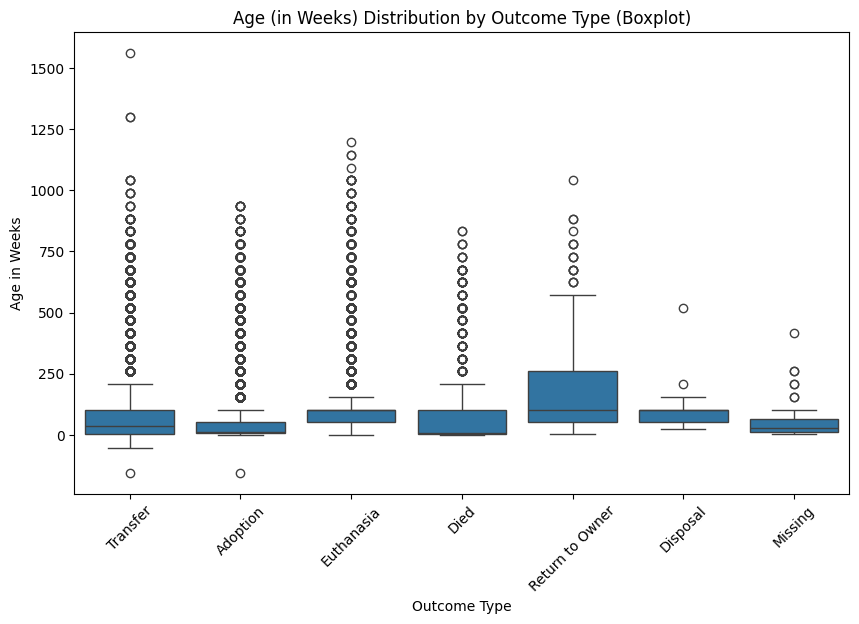

In [11]:
# ========== Boxplot to show AgeWeeks by Outcome Type ==========
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Outcome Type', y='AgeWeeks')
plt.xticks(rotation=45)
plt.title('Age (in Weeks) Distribution by Outcome Type (Boxplot)')
plt.ylabel('Age in Weeks')
plt.xlabel('Outcome Type')
plt.show()